In [62]:
import pandas as pd
method = 'CBLOF'

cae_df = pd.read_csv(f"experiments/Outlier_Detection/COMPETITORS/Results_CAE_{[method]}_all_datasets.csv")
elm_df =  pd.read_csv(f"experiments/Outlier_Detection/COMPETITORS/Results_ELM_{[method]}_all_datasets.csv")
hics_df = pd.read_csv(f"experiments/Outlier_Detection/COMPETITORS/Results_HiCS_{[method]}_all_datasets.csv")
gmd_df = pd.read_csv(f"experiments/Outlier_Detection/COMPETITORS/Results_GMD_{[method]}_all_datasets.csv")
pca_df = pd.read_csv(f"experiments/Outlier_Detection/COMPETITORS/Results_PCA_{[method]}_all_datasets.csv")
umap_df = pd.read_csv(f"experiments/Outlier_Detection/COMPETITORS/Results_UMAP_{[method]}_all_datasets.csv")
clique_df = pd.read_csv(f"experiments/Outlier_Detection/COMPETITORS/Results_CLIQUE_{[method]}_all_datasets.csv")



pvalue_df = pd.read_csv(f"experiments/Outlier_Detection/Results_GOF_VGAN_all_datasets.csv")
statistics_df = pd.read_csv(f"experiments/Outlier_Detection/dataset_statistics.csv")

# Function to group by Dataset and Method, and calculate the average AUC
def group_by_dataset_method_avg_auc(df):
    grouped_df = df.groupby(['Dataset', 'Method'])['AUC'].mean().reset_index()
    return grouped_df

# Apply the function to the loaded dataframe
cae_df = group_by_dataset_method_avg_auc(cae_df)
elm_df = group_by_dataset_method_avg_auc(elm_df)
hics_df = group_by_dataset_method_avg_auc(hics_df)
gmd_df = group_by_dataset_method_avg_auc(gmd_df)
pca_df = group_by_dataset_method_avg_auc(pca_df)
umap_df = group_by_dataset_method_avg_auc(umap_df)
clique_df = group_by_dataset_method_avg_auc(clique_df)



grouped_df_1 = pd.merge(cae_df,elm_df[['Dataset','AUC']], on = 'Dataset', how = 'outer')
grouped_df_2 = pd.merge(grouped_df_1, hics_df[['Dataset','AUC']], on = 'Dataset', how = 'outer')
grouped_df_2 = grouped_df_2.rename(columns = {'AUC_x': 'CAE', 'AUC_y': 'ELM', 'AUC':'HiCS'})
grouped_df_3 = pd.merge(grouped_df_2, gmd_df[['Dataset','AUC']], on = 'Dataset', how = 'outer')
grouped_df_4 = pd.merge(grouped_df_3, pca_df[['Dataset','AUC']], on = 'Dataset', how = 'outer')
grouped_df_5 = pd.merge(grouped_df_4, umap_df[['Dataset','AUC']], on = 'Dataset', how = 'outer')
grouped_df_5 = grouped_df_5.rename(columns = {'AUC_x': 'GMD', 'AUC_y': 'PCA', 'AUC':'UMAP'})
grouped_df = pd.merge(grouped_df_5, clique_df[['Dataset','AUC']], on = 'Dataset', how = 'outer')
grouped_df = grouped_df.rename(columns = {'AUC':'CLIQUE'}).fillna(0)
pd.merge(grouped_df,statistics_df[["Dataset","# Features"]], on = 'Dataset', how = 'outer').sort_values("# Features", ascending=False) 

grouped_df = pd.merge(grouped_df,statistics_df[["Dataset","# Features"]], on = 'Dataset', how = 'outer').sort_values("# Features", ascending=False).reset_index().drop("# Features", axis=1).drop("index",axis=1)
grouped_df.to_csv("res.csv", sep=";")

In [86]:
grouped_df

,Dataset,Method,CAE,ELM,HiCS,GMD,PCA,UMAP,CLIQUE
0,InternetAds,KNN,0.603736,0.840252,0.871637,0.881445,0.557821,0.691000,0.000000
1,20news_0,KNN,0.665883,0.681913,0.521333,0.689335,0.611955,0.477930,0.000000
2,imdb,KNN,0.552606,0.530946,0.517718,0.530414,0.531033,0.528561,0.000000
3,agnews_0,KNN,0.509204,0.556902,0.466265,0.553275,0.530321,0.573520,0.000000
4,amazon,KNN,0.571736,0.586028,0.532782,0.589772,0.581756,0.475711,0.000000
5,yelp,KNN,0.601928,0.644826,0.552580,0.646605,0.639798,0.489047,0.000000
6,MNIST-C_brightness,KNN,0.785897,0.856762,0.646410,0.785432,0.862118,0.567021,0.000000
7,MVTec-AD_bottle,KNN,0.965839,0.966563,0.927881,0.973085,0.971705,0.387164,0.000000
8,CIFAR10_0,KNN,0.693289,0.767126,0.703677,0.743160,0.781175,0.500251,0.000000
9,FashionMNIST_0,KNN,0.839987,0.903519,0.847718,0.864923,0.908283,0.574730,0.000000


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import os

os.environ["PATH"] += os.pathsep + '/home/i40/cribeiro/usr/local/texlive/2024/bin/x86_64-linux'
print(os.getenv("PATH"))
latex_preamble = """
\\usepackage[utf8]{inputenc}
\\usepackage{microtype}
\\usepackage{amsmath}
\\renewcommand{\\rmdefault}{ptm}
\\renewcommand{\\sfdefault}{phv}
"""
fs = 9
column_width = 3.3249219444  # inch
text_width = 7.02625  # inch
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": latex_preamble,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "font.size": fs,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "savefig.bbox": "tight",
})


/home/i40/cribeiro/anaconda3/envs/subsel_torch/bin:/home/i40/cribeiro/anaconda3/condabin:/home/i40/cribeiro/.vscode-server/bin/8b3775030ed1a69b13e4f4c628c612102e30a681/bin/remote-cli:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/usr/local/cuda/bin:/home/i40/cribeiro/usr/local/texlive/2024/bin/x86_64-linux:/home/i40/cribeiro/usr/local/texlive/2024/bin/x86_64-linux:/home/i40/cribeiro/usr/local/texlive/2024/bin/x86_64-linux:/home/i40/cribeiro/usr/local/texlive/2024/bin/x86_64-linux:/home/i40/cribeiro/usr/local/texlive/2024/bin/x86_64-linux:/home/i40/cribeiro/usr/local/texlive/2024/bin/x86_64-linux:/home/i40/cribeiro/usr/local/texlive/2024/bin/x86_64-linux


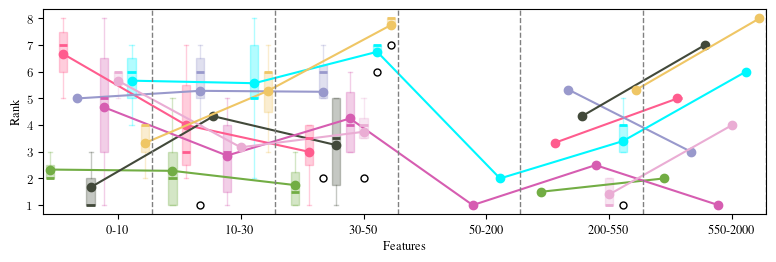

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

#Define the dataset 
odm = "CBLOF"
type_u = "lense"
# Load the CSV file
df = pd.read_csv(f'experiments/Outlier_Detection/COMPETITORS/full_tables_with_rank/{odm}_res.csv', delimiter=',',)

# Filter the datasets where p-value > 0.10
filtered_pvalue_df = df
if type_u == "lense":
    filtered_pvalue_df = df[df['p-value'] > 0.10]
else :
    filtered_pvalue_df = df[df['p-value'] < 0.10]
    type_u = "non-lense"

#Define the colors to use
vgan_color = "#72AD44"
cae_color = "#FF5C8E"
elm_color = "#9999CC"
hics_color = "#42493A"
clique_color = "#EFC665"
gmd_color = "#D65DB1"
pca_color = "#EAADD4"
umap_color = "#00F8FF"
fs_color =  "#68004D"

# Further filter by the feature ranges
# Further filter by the feature ranges
filtered_pvalue_0_10 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 0) & (filtered_pvalue_df['# Features'] <= 8)]
filtered_pvalue_10_30 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 10) & (filtered_pvalue_df['# Features'] <= 30)]
filtered_pvalue_30_50 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 30) & (filtered_pvalue_df['# Features'] < 50)]
filtered_pvalue_50_100 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 50) & (filtered_pvalue_df['# Features'] <= 200)]
filtered_pvalue_100_300 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 200) & (filtered_pvalue_df['# Features'] <= 550)]
filtered_pvalue_300_700 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 550) & (filtered_pvalue_df['# Features'] <= 2000)]
filtered_pvalue_700_2000 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 700) & (filtered_pvalue_df['# Features'] <= 2000)]

# Extract VGAN, ENSEMBLE, and FS ranks for these filtered datasets
vgan_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK VGAN']
vgan_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK VGAN']
vgan_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK VGAN']
vgan_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK VGAN']
vgan_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK VGAN']
vgan_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK VGAN']
vgan_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK VGAN']

cae_pvalue_ranks_0_10     =     filtered_pvalue_0_10['RANK CAE']
cae_pvalue_ranks_10_30    =    filtered_pvalue_10_30['RANK CAE']
cae_pvalue_ranks_30_50    =    filtered_pvalue_30_50['RANK CAE']
cae_pvalue_ranks_50_100   =   filtered_pvalue_50_100['RANK CAE']
cae_pvalue_ranks_100_300  =  filtered_pvalue_100_300['RANK CAE']
cae_pvalue_ranks_300_700  =  filtered_pvalue_300_700['RANK CAE']
cae_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK CAE']

hics_pvalue_ranks_0_10     =     filtered_pvalue_0_10['RANK HiCS']
hics_pvalue_ranks_10_30    =    filtered_pvalue_10_30['RANK HiCS']
hics_pvalue_ranks_30_50    =    filtered_pvalue_30_50['RANK HiCS']
hics_pvalue_ranks_50_100   =   filtered_pvalue_50_100['RANK HiCS']
hics_pvalue_ranks_100_300  =  filtered_pvalue_100_300['RANK HiCS']
hics_pvalue_ranks_300_700  =  filtered_pvalue_300_700['RANK HiCS']
hics_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK HiCS']

elm_pvalue_ranks_0_10     =     filtered_pvalue_0_10['RANK ELM']
elm_pvalue_ranks_10_30    =    filtered_pvalue_10_30['RANK ELM']
elm_pvalue_ranks_30_50    =    filtered_pvalue_30_50['RANK ELM']
elm_pvalue_ranks_50_100   =   filtered_pvalue_50_100['RANK ELM']
elm_pvalue_ranks_100_300  =  filtered_pvalue_100_300['RANK ELM']
elm_pvalue_ranks_300_700  =  filtered_pvalue_300_700['RANK ELM']
elm_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK ELM']

gmd_pvalue_ranks_0_10     =     filtered_pvalue_0_10['RANK GMD']
gmd_pvalue_ranks_10_30    =    filtered_pvalue_10_30['RANK GMD']
gmd_pvalue_ranks_30_50    =    filtered_pvalue_30_50['RANK GMD']
gmd_pvalue_ranks_50_100   =   filtered_pvalue_50_100['RANK GMD']
gmd_pvalue_ranks_100_300  =  filtered_pvalue_100_300['RANK GMD']
gmd_pvalue_ranks_300_700  =  filtered_pvalue_300_700['RANK GMD']
gmd_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK GMD']

pca_pvalue_ranks_0_10     =     filtered_pvalue_0_10['RANK PCA']
pca_pvalue_ranks_10_30    =    filtered_pvalue_10_30['RANK PCA']
pca_pvalue_ranks_30_50    =    filtered_pvalue_30_50['RANK PCA']
pca_pvalue_ranks_50_100   =   filtered_pvalue_50_100['RANK PCA']
pca_pvalue_ranks_100_300  =  filtered_pvalue_100_300['RANK PCA']
pca_pvalue_ranks_300_700  =  filtered_pvalue_300_700['RANK PCA']
pca_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK PCA']

umap_pvalue_ranks_0_10     =     filtered_pvalue_0_10['RANK UMAP']
umap_pvalue_ranks_10_30    =    filtered_pvalue_10_30['RANK UMAP']
umap_pvalue_ranks_30_50    =    filtered_pvalue_30_50['RANK UMAP']
umap_pvalue_ranks_50_100   =   filtered_pvalue_50_100['RANK UMAP']
umap_pvalue_ranks_100_300  =  filtered_pvalue_100_300['RANK UMAP']
umap_pvalue_ranks_300_700  =  filtered_pvalue_300_700['RANK UMAP']
umap_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK UMAP']

clique_pvalue_ranks_0_10     =     filtered_pvalue_0_10['RANK CLIQUE']
clique_pvalue_ranks_10_30    =    filtered_pvalue_10_30['RANK CLIQUE']
clique_pvalue_ranks_30_50    =    filtered_pvalue_30_50['RANK CLIQUE']
clique_pvalue_ranks_50_100   =   filtered_pvalue_50_100['RANK CLIQUE']
clique_pvalue_ranks_100_300  =  filtered_pvalue_100_300['RANK CLIQUE']
clique_pvalue_ranks_300_700  =  filtered_pvalue_300_700['RANK CLIQUE']
clique_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK CLIQUE']



# Calculating the average ranks for each group
all_averages = {
    "0-10": vgan_pvalue_ranks_0_10.mean(),
    "10-30": vgan_pvalue_ranks_10_30.mean(),
    "30-50": vgan_pvalue_ranks_30_50.mean(),
    "50-100": vgan_pvalue_ranks_50_100.mean(),
    "100-300": vgan_pvalue_ranks_100_300.mean(),
    "300-700": vgan_pvalue_ranks_300_700.mean(),
    "700-2000": vgan_pvalue_ranks_700_2000.mean()
}


# Creating the combined boxplot with individual boxplots, line plots of the average ranks, and vertical lines to indicate group limits
plt.figure(figsize=(4*7/3, 2*4/3))
pos = np.array([1, 10, 19, 28, 37, 46])

# Creating the boxplots for VGAN, ENSEMBLE, and FS
boxplot_vgan = plt.boxplot(
    [vgan_pvalue_ranks_0_10, vgan_pvalue_ranks_10_30, vgan_pvalue_ranks_30_50, vgan_pvalue_ranks_50_100,
        vgan_pvalue_ranks_100_300, vgan_pvalue_ranks_300_700],
    positions=pos,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=vgan_color, color=vgan_color, alpha=0.3),
    whiskerprops=dict(color=vgan_color, alpha=0.3),
    capprops=dict(color=vgan_color, alpha=0.3),
    medianprops=dict(color=vgan_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5,
                    linestyle='none', linewidth=2, color=vgan_color)
)

boxplot_cae = plt.boxplot(
    [cae_pvalue_ranks_0_10, cae_pvalue_ranks_10_30, cae_pvalue_ranks_30_50, cae_pvalue_ranks_50_100,
        cae_pvalue_ranks_100_300, cae_pvalue_ranks_300_700],
    positions=pos + 1,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=cae_color, color=cae_color, alpha=0.3),
    whiskerprops=dict(color=cae_color, alpha=0.3),
    capprops=dict(color=cae_color, alpha=0.3),
    medianprops=dict(color=cae_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=cae_color)
)


boxplot_elm = plt.boxplot(
    [elm_pvalue_ranks_0_10, elm_pvalue_ranks_10_30, elm_pvalue_ranks_30_50, elm_pvalue_ranks_50_100,
        elm_pvalue_ranks_100_300, elm_pvalue_ranks_300_700],
    positions= pos + 2,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=elm_color, color=elm_color, alpha=0.3),
    whiskerprops=dict(color=elm_color, alpha=0.3),
    capprops=dict(color=elm_color, alpha=0.3),
    medianprops=dict(color=elm_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=elm_color)
)

boxplot_hics = plt.boxplot(
    [hics_pvalue_ranks_0_10, hics_pvalue_ranks_10_30, hics_pvalue_ranks_30_50, hics_pvalue_ranks_50_100,
        hics_pvalue_ranks_100_300, hics_pvalue_ranks_300_700],
    positions=pos + 3,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=hics_color, color=hics_color, alpha=0.3),
    whiskerprops=dict(color=hics_color, alpha=0.3),
    capprops=dict(color=hics_color, alpha=0.3),
    medianprops=dict(color=hics_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=hics_color)
)

boxplot_gmd = plt.boxplot(
    [gmd_pvalue_ranks_0_10, gmd_pvalue_ranks_10_30, gmd_pvalue_ranks_30_50, gmd_pvalue_ranks_50_100,
        gmd_pvalue_ranks_100_300, gmd_pvalue_ranks_300_700],
    positions= pos + 4,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=gmd_color, color=gmd_color, alpha=0.3),
    whiskerprops=dict(color=gmd_color, alpha=0.3),
    capprops=dict(color=gmd_color, alpha=0.3),
    medianprops=dict(color=gmd_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=gmd_color)
)

boxplot_pca = plt.boxplot(
    [pca_pvalue_ranks_0_10, pca_pvalue_ranks_10_30, pca_pvalue_ranks_30_50, pca_pvalue_ranks_50_100,
        pca_pvalue_ranks_100_300, pca_pvalue_ranks_300_700],
    positions=pos + 5,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=pca_color, color=pca_color, alpha=0.3),
    whiskerprops=dict(color=pca_color, alpha=0.3),
    capprops=dict(color=pca_color, alpha=0.3),
    medianprops=dict(color=pca_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=pca_color)
)

boxplot_umap = plt.boxplot(
    [umap_pvalue_ranks_0_10, umap_pvalue_ranks_10_30, umap_pvalue_ranks_30_50, umap_pvalue_ranks_50_100,
        umap_pvalue_ranks_100_300, umap_pvalue_ranks_300_700],
    positions=pos + 6,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=umap_color, color=umap_color, alpha=0.3),
    whiskerprops=dict(color=umap_color, alpha=0.3),
    capprops=dict(color=umap_color, alpha=0.3),
    medianprops=dict(color=umap_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=umap_color)
)

boxplot_clique = plt.boxplot(
    [clique_pvalue_ranks_0_10, clique_pvalue_ranks_10_30, clique_pvalue_ranks_30_50, clique_pvalue_ranks_50_100,
        clique_pvalue_ranks_100_300, clique_pvalue_ranks_300_700],
    positions=pos + 7,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=clique_color, color=clique_color, alpha=0.3),
    whiskerprops=dict(color=clique_color, alpha=0.3),
    capprops=dict(color=clique_color, alpha=0.3),
    medianprops=dict(color=clique_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=clique_color)
)


# Plotting the average ranks for VGAN, ENSEMBLE, and FS as line plots on top of the boxplots
plt.plot(
    pos,
    [all_averages["0-10"], all_averages["10-30"], all_averages["30-50"], all_averages["50-100"],
        all_averages["100-300"], all_averages["300-700"]],
    color=vgan_color, marker='o', linestyle='-', linewidth=1.5, label='VGAN'
)

plt.plot(
    pos + 1,
    [cae_pvalue_ranks_0_10.mean(), cae_pvalue_ranks_10_30.mean(), cae_pvalue_ranks_30_50.mean(), cae_pvalue_ranks_50_100.mean(),
     cae_pvalue_ranks_100_300.mean(), cae_pvalue_ranks_300_700.mean()],
    color=cae_color, marker='o', linestyle='-', linewidth=1.5, label='CAE'
)

plt.plot(
    pos + 2,
    [elm_pvalue_ranks_0_10.mean(), elm_pvalue_ranks_10_30.mean(), elm_pvalue_ranks_30_50.mean(), elm_pvalue_ranks_50_100.mean(),
     elm_pvalue_ranks_100_300.mean(), elm_pvalue_ranks_300_700.mean()],
    color=elm_color, marker='o', linestyle='-', linewidth=1.5, label='ELM'
)

plt.plot(
    pos + 3,
    [hics_pvalue_ranks_0_10.mean(), hics_pvalue_ranks_10_30.mean(), hics_pvalue_ranks_30_50.mean(), hics_pvalue_ranks_50_100.mean(),
     hics_pvalue_ranks_100_300.mean(), hics_pvalue_ranks_300_700.mean()],
    color=hics_color, marker='o', linestyle='-', linewidth=1.5, label='HiCS'
)

plt.plot(
    pos + 4,
    [gmd_pvalue_ranks_0_10.mean(), gmd_pvalue_ranks_10_30.mean(), gmd_pvalue_ranks_30_50.mean(), gmd_pvalue_ranks_50_100.mean(),
     gmd_pvalue_ranks_100_300.mean(), gmd_pvalue_ranks_300_700.mean()],
    color=gmd_color, marker='o', linestyle='-', linewidth=1.5, label='GMD'
)

plt.plot(
    pos + 5,
    [pca_pvalue_ranks_0_10.mean(), pca_pvalue_ranks_10_30.mean(), pca_pvalue_ranks_30_50.mean(), pca_pvalue_ranks_50_100.mean(),
     pca_pvalue_ranks_100_300.mean(), pca_pvalue_ranks_300_700.mean()],
    color=pca_color, marker='o', linestyle='-', linewidth=1.5, label='PCA'
)

plt.plot(
    pos + 6,
    [umap_pvalue_ranks_0_10.mean(), umap_pvalue_ranks_10_30.mean(), umap_pvalue_ranks_30_50.mean(), umap_pvalue_ranks_50_100.mean(),
     umap_pvalue_ranks_100_300.mean(), umap_pvalue_ranks_300_700.mean()],
    color=umap_color, marker='o', linestyle='-', linewidth=1.5, label='UMAP'
)

plt.plot(
    pos + 7,
    [clique_pvalue_ranks_0_10.mean(), clique_pvalue_ranks_10_30.mean(), clique_pvalue_ranks_30_50.mean(), clique_pvalue_ranks_50_100.mean(),
     clique_pvalue_ranks_100_300.mean(), clique_pvalue_ranks_300_700.mean()],
    color=clique_color, marker='o', linestyle='-', linewidth=1.5, label='CLIQUE'
)



# Adding vertical lines to indicate the limits of each group on the x-axis
for x in pos + 7.5:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)

# Setting the x-axis labels
plt.xticks(pos + 5, ['0-10', '10-30',
           '30-50', '50-200', '200-550', '550-2000'])

plt.xlabel('Features')
plt.ylabel('Rank')
if odm == "LOF":
    legend = plt.legend(ncols = 1)
    legend.set_alpha(.1)

#legend.set_bbox_to_anchor((.45,.1))
plt.savefig(f'experiments/Outlier_Detection/COMPETITORS/{odm}_{type_u}.png',dpi=1000)
plt.show()

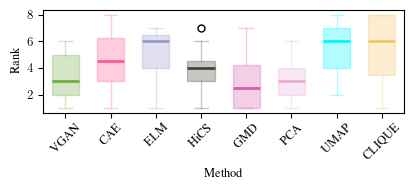

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

#Define the dataset 
odm = "CBLOF"
type_u = "non-lense"
# Load the CSV file
df = pd.read_csv(f'experiments/Outlier_Detection/COMPETITORS/full_tables_with_rank/{odm}_res.csv', delimiter=',',)

# Filter the datasets where p-value > 0.10
filtered_pvalue_df = df
if type_u == "lense":
    filtered_pvalue_df = df[df['p-value'] > 0.10]
else :
    filtered_pvalue_df = df[df['p-value'] < 0.10]
    type_u = "non-lense"

#Define the colors to use
vgan_color = "#72AD44"
cae_color = "#FF5C8E"
elm_color = "#9999CC"
hics_color = "#42493A"
clique_color = "#EFC665"
gmd_color = "#D65DB1"
pca_color = "#EAADD4"
umap_color = "#00F8FF"



# Extract VGAN, ENSEMBLE, and FS ranks for these filtered datasets
vgan_pvalue_ranks = filtered_pvalue_df['RANK VGAN'].dropna().to_numpy()

cae_pvalue_ranks     =     filtered_pvalue_df['RANK CAE'].dropna().to_numpy()

hics_pvalue_ranks    =     filtered_pvalue_df['RANK HiCS'].dropna().to_numpy()

elm_pvalue_ranks     =     filtered_pvalue_df['RANK ELM'].dropna().to_numpy()

gmd_pvalue_ranks     =     filtered_pvalue_df['RANK GMD'].dropna().to_numpy()

pca_pvalue_ranks     =     filtered_pvalue_df['RANK PCA'].dropna().to_numpy()

umap_pvalue_ranks     =     filtered_pvalue_df['RANK UMAP'].dropna().to_numpy()

clique_pvalue_ranks    =     filtered_pvalue_df['RANK CLIQUE'].dropna().to_numpy()




# Creating the combined boxplot with individual boxplots, line plots of the average ranks, and vertical lines to indicate group limits
plt.figure(figsize=(2*7/3, 4/3))
pos = np.array([1])

# Creating the boxplots for VGAN, ENSEMBLE, and FS
boxplot_vgan = plt.boxplot(
    vgan_pvalue_ranks,
    positions=pos,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=vgan_color, color=vgan_color, alpha=0.3),
    whiskerprops=dict(color=vgan_color, alpha=0.3),
    capprops=dict(color=vgan_color, alpha=0.3),
    medianprops=dict(color=vgan_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5,
                    linestyle='none', linewidth=2, color=vgan_color)
)

boxplot_cae = plt.boxplot(
    [cae_pvalue_ranks],
    positions=pos + 1,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=cae_color, color=cae_color, alpha=0.3),
    whiskerprops=dict(color=cae_color, alpha=0.3),
    capprops=dict(color=cae_color, alpha=0.3),
    medianprops=dict(color=cae_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=cae_color)
)


boxplot_elm = plt.boxplot(
    [elm_pvalue_ranks],
    positions= pos + 2,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=elm_color, color=elm_color, alpha=0.3),
    whiskerprops=dict(color=elm_color, alpha=0.3),
    capprops=dict(color=elm_color, alpha=0.3),
    medianprops=dict(color=elm_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=elm_color)
)

boxplot_hics = plt.boxplot(
    [hics_pvalue_ranks],
    positions=pos + 3,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=hics_color, color=hics_color, alpha=0.3),
    whiskerprops=dict(color=hics_color, alpha=0.3),
    capprops=dict(color=hics_color, alpha=0.3),
    medianprops=dict(color=hics_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=hics_color)
)

boxplot_gmd = plt.boxplot(
    [gmd_pvalue_ranks],
    positions= pos + 4,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=gmd_color, color=gmd_color, alpha=0.3),
    whiskerprops=dict(color=gmd_color, alpha=0.3),
    capprops=dict(color=gmd_color, alpha=0.3),
    medianprops=dict(color=gmd_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=gmd_color)
)

boxplot_pca = plt.boxplot(
    [pca_pvalue_ranks],
    positions=pos + 5,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=pca_color, color=pca_color, alpha=0.3),
    whiskerprops=dict(color=pca_color, alpha=0.3),
    capprops=dict(color=pca_color, alpha=0.3),
    medianprops=dict(color=pca_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=pca_color)
)

boxplot_umap = plt.boxplot(
    [umap_pvalue_ranks],
    positions=pos + 6,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=umap_color, color=umap_color, alpha=0.3),
    whiskerprops=dict(color=umap_color, alpha=0.3),
    capprops=dict(color=umap_color, alpha=0.3),
    medianprops=dict(color=umap_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=umap_color)
)

boxplot_clique = plt.boxplot(
    [clique_pvalue_ranks],
    positions=pos + 7,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=clique_color, color=clique_color, alpha=0.3),
    whiskerprops=dict(color=clique_color, alpha=0.3),
    capprops=dict(color=clique_color, alpha=0.3),
    medianprops=dict(color=clique_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=clique_color)
)





# Setting the x-axis labels
plt.xticks([1,2,3,4,5,6,7,8], ["VGAN","CAE","ELM", "HiCS","GMD","PCA","UMAP","CLIQUE"], rotation=45)

plt.xlabel('Method')
plt.ylabel('Rank')
if odm == "LOF":
    legend = plt.legend(ncols = 1)
    legend.set_alpha(.1)

#legend.set_bbox_to_anchor((.45,.1))
plt.savefig(f'experiments/Outlier_Detection/COMPETITORS/{odm}_{type_u}_together.png',dpi=1000)
plt.show()

# CONOVER-IMAN

In [70]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import numpy as np 

#Specify the odm
odm = "CBLOF"

# Load the data
df = pd.read_csv(f'experiments/Outlier_Detection/COMPETITORS/full_tables_with_rank/{odm}_res.csv', delimiter=',')

#Using a lense operator
df = df[df['p-value'] > 0.10]

# Extracting the ranks for each model
ranks_cae = df['RANK CAE'].dropna()
ranks_hics = df['RANK HiCS'].dropna()
ranks_vgan = df['RANK VGAN'].dropna()
ranks_clique = df['RANK CLIQUE'].dropna()
ranks_elm = df['RANK ELM'].dropna()
ranks_gmd = df['RANK GMD'].dropna()
ranks_pca = df['RANK PCA'].dropna()
ranks_umap = df['RANK UMAP'].dropna()

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_cae, ranks_hics, ranks_clique, ranks_elm, ranks_gmd,ranks_pca,ranks_umap,ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test
conover_result = sp.posthoc_conover([ranks_cae, ranks_hics, ranks_clique, ranks_elm, ranks_gmd,ranks_pca,ranks_umap,ranks_vgan])
conover_result.index = ["CAE", "HiCS", "CLIQUE", "ELM", "GMD","PCA","UMAP","VGAN"]
conover_result.columns =  ["CAE", "HiCS", "CLIQUE", "ELM", "GMD","PCA","UMAP","VGAN"]





# Calculate the average ranks for each method
avg_ranks = pd.DataFrame({
    'CAE': [np.mean(ranks_cae)],
    'HiCS': [np.mean(ranks_hics)],
    'CLIQUE': [np.mean(ranks_clique)],
    'ELM': [np.mean(ranks_elm)],
    'GMD': [np.mean(ranks_gmd)],
    'PCA': [np.mean(ranks_pca)],
    'UMAP': [np.mean(ranks_umap)],
    'VGAN': [np.mean(ranks_vgan)]
}).T
avg_ranks.columns = ['Average Rank']
avg_ranks = avg_ranks.sort_values(by='Average Rank')  # Sort by rank if necessary



# Create a matrix for storing the + and ++ symbols
symbol_matrix = pd.DataFrame('', index=conover_result.index, columns=conover_result.columns)

# Fill in the matrix based on the p-value and average rank conditions
for row in conover_result.index:
    for col in conover_result.columns:
        if row != col:  # No comparison with itself
            p_value = conover_result.loc[row, col]
            if p_value <= 0.10 and avg_ranks.loc[row, 'Average Rank'] < avg_ranks.loc[col, 'Average Rank']:
                if p_value <= 0.05:
                    symbol_matrix.loc[row, col] = '++'
                else:
                    symbol_matrix.loc[row, col] = '+'
            if p_value <= 0.10 and avg_ranks.loc[row, 'Average Rank'] > avg_ranks.loc[col, 'Average Rank']:
                if p_value <= 0.05:
                    symbol_matrix.loc[row, col] = '--'
                else:
                    symbol_matrix.loc[row, col] = '-'
        if row == col:
            symbol_matrix.loc[row,col] = "="

print(f"\nThis leads to a symbolic matrix of:\n {symbol_matrix}")

Kruskal-Wallis Test Result: KruskalResult(statistic=41.13073194533645, pvalue=7.641253893435835e-07)

This leads to a symbolic matrix of:
        CAE HiCS CLIQUE ELM GMD PCA UMAP VGAN
CAE      =          ++                    --
HiCS          =     ++  ++           ++   --
CLIQUE  --   --      =      --  --        --
ELM          --          =  --  --        --
GMD                 ++  ++   =       ++    -
PCA                 ++  ++       =   ++   --
UMAP         --             --  --    =   --
VGAN    ++   ++     ++  ++   +  ++   ++    =


In [71]:
conover_result

,CAE,HiCS,CLIQUE,ELM,GMD,PCA,UMAP,VGAN
CAE,1.000000,0.429126,1.929864e-02,0.108423,0.115461,0.142444,1.034259e-01,8.005866e-04
HiCS,0.429126,1.000000,3.137561e-03,0.023139,0.492032,0.565970,2.046798e-02,1.634270e-02
CLIQUE,0.019299,0.003138,1.000000e+00,0.473935,0.000124,0.000166,4.147730e-01,5.364010e-08
ELM,0.108423,0.023139,4.739353e-01,1.000000,0.001843,0.002428,9.514498e-01,1.954155e-06
GMD,0.115461,0.492032,1.244802e-04,0.001843,1.000000,0.896575,1.306518e-03,6.378277e-02
PCA,0.142444,0.565970,1.658287e-04,0.002428,0.896575,1.000000,1.737597e-03,4.518418e-02
UMAP,0.103426,0.020468,4.147730e-01,0.951450,0.001307,0.001738,1.000000e+00,8.295934e-07
VGAN,0.000801,0.016343,5.364010e-08,0.000002,0.063783,0.045184,8.295934e-07,1.000000e+00
